In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from redist import modifier
from redist import plot
from knunu_utils import * 

# Reinterpreting $B \to K \nu \nu$ in terms of the WET

Here the differential branching ratio prediction is a function of one kinematic variable: $q^2$.

We use $q^2$ also as the fitting variable, but with a different binning than for the reweighting.

## Define the binning

In [2]:
binning = np.linspace(0.0, 22.9, 13) 
bin_cents = (binning[:-1] + binning[1:])/2
q2binning = np.linspace(0.0, 22.9, 24)

## Define the NP model in WC space

In [3]:
cvl = 5.0
cvr = 1.0
csl = 1.0
csr = 1.0
ctl = 1.0

## Generate some SM samples

In [4]:
SMsamples = 500000

p = analysis().parameters
k = eos.Kinematics(q2=1.0, q2_min=0.0, q2_max=22.90)
o = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})

pdf = eos.SignalPDF.make('B^-->K^-nunu::dGamma/dq2', p, k, o)
obs = eos.Observable.make('B->Knunu::BR', p, k, o)
SMBR = obs.evaluate()

null_samples, pdf_values = pdf.sample_mcmc(SMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1111))

/home/lorenz/venv_redist/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Smear samples with Gaussian resolution function and apply efficiency


In [5]:
np.random.seed(2222)
null_samples_smeared = np.random.normal(null_samples, 1.0, null_samples.shape)
null_samples_smeared = np.abs(null_samples_smeared)

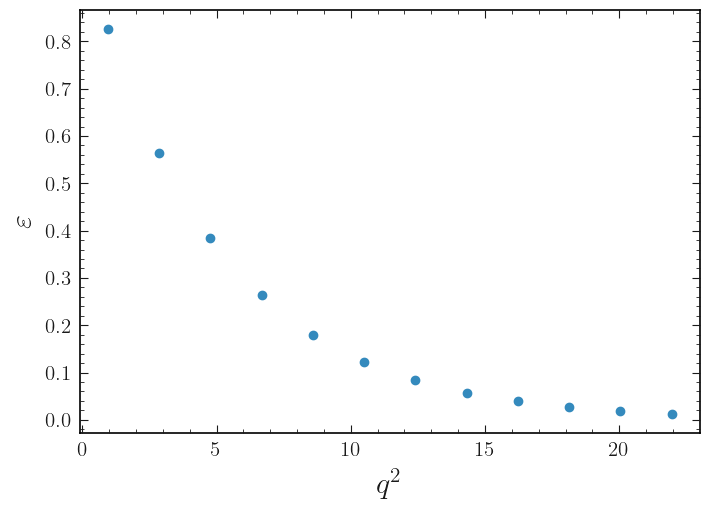

In [6]:
plt.plot(bin_cents, efficiency(bin_cents), "o")

plt.xlabel(r'$q^2$')
plt.ylabel(r'$\varepsilon$')
plt.show()

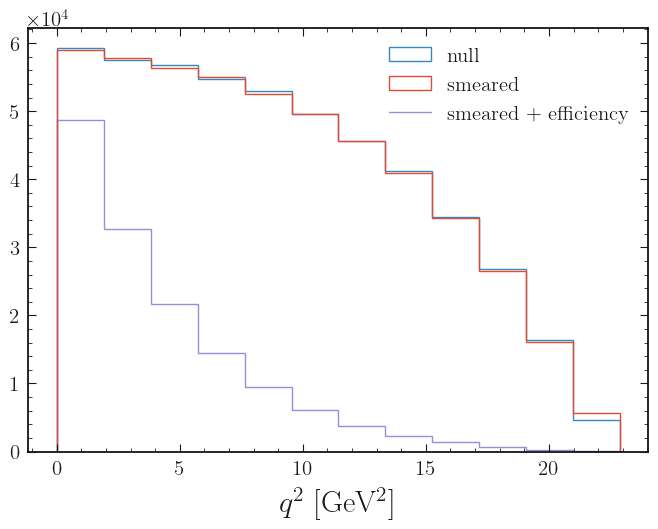

In [7]:
plt.hist(null_samples, binning, histtype='step', label='null')
null_yields, _, _ = plt.hist(null_samples_smeared, binning, histtype='step', label='smeared')
null_yields *= efficiency(bin_cents)
plt.stairs(null_yields, binning, label='smeared + efficiency')
plt.xlabel(r'$q^2$ [GeV$^2$]')
plt.legend()

## Generate some fake data according to some NP model

Need to scale the number of samples here, because if NP would exist, we would also see a total different count of events.

In [8]:
p['sbnunu::Re{cVL}'].set(cvl)
p['sbnunu::Re{cVR}'].set(cvr)
p['sbnunu::Re{cSL}'].set(csl)
p['sbnunu::Re{cSR}'].set(csr)
p['sbnunu::Re{cTL}'].set(ctl)


BSMBR = obs.evaluate()

BSMsamples = int(SMsamples*BSMBR/SMBR)
alt_samples, pdf_values = pdf.sample_mcmc(BSMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=3333))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [9]:
np.random.seed(4444)
alt_samples_smeared = np.random.normal(alt_samples, 1.0, alt_samples.shape)
alt_samples_smeared = np.abs(alt_samples_smeared)

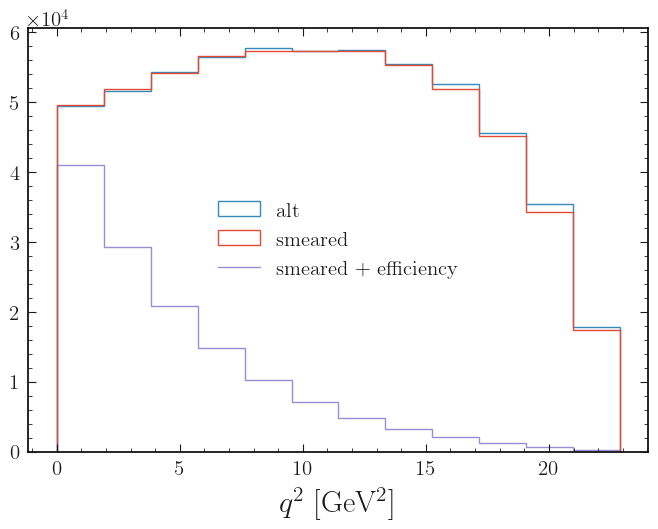

In [10]:
plt.hist(alt_samples, binning, histtype='step', label='alt')
alt_yields, _, _ = plt.hist(alt_samples_smeared, binning, histtype='step', label='smeared')
alt_yields *= efficiency(bin_cents)
plt.stairs(alt_yields, binning, label='smeared + efficiency')
plt.xlabel(r'$q^2$ [GeV$^2$]')
plt.legend()

## Set up the mapping distribution

In [11]:
mapping_dist = np.histogramdd([null_samples.flatten(), null_samples_smeared.flatten()], bins=[binning, q2binning])[0]
mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

## Set up the custom modifier

In [12]:
null = null_pred()
alt = alt_pred()

In [13]:
ana = analysis()

fp0 = ana.parameters['B->K::alpha^f+_0@BSZ2015'].evaluate()
fp1 = ana.parameters['B->K::alpha^f+_1@BSZ2015'].evaluate()
fp2 = ana.parameters['B->K::alpha^f+_2@BSZ2015'].evaluate()
f01 = ana.parameters['B->K::alpha^f0_1@BSZ2015'].evaluate()
f02 = ana.parameters['B->K::alpha^f0_2@BSZ2015'].evaluate()
fT0 = ana.parameters['B->K::alpha^fT_0@BSZ2015'].evaluate()
fT1 = ana.parameters['B->K::alpha^fT_1@BSZ2015'].evaluate()
fT2 = ana.parameters['B->K::alpha^fT_2@BSZ2015'].evaluate()

In [14]:
# Get covariance matrix of hadronic parameters
cov = parameter_cov(alt.ana)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7
0,0.000109,0.000696,0.000979,0.000775,0.001303,0.000088,0.000565,0.000760
1,0.000696,0.009307,0.021609,0.005688,0.010247,0.000392,0.006202,0.014710
2,0.000979,0.021609,0.067185,0.008526,0.017058,0.000097,0.011229,0.042544
3,0.000775,0.005688,0.008526,0.006233,0.011288,0.000612,0.004714,0.006588
4,0.001303,0.010247,0.017058,0.011288,0.022037,0.000978,0.008112,0.012782
5,0.000088,0.000392,0.000097,0.000612,0.000978,0.000473,0.003446,0.005830
6,0.000565,0.006202,0.011229,0.004714,0.008112,0.003446,0.031871,0.061918
7,0.000760,0.014710,0.042544,0.006588,0.012782,0.005830,0.061918,0.144128


In [15]:
cvlSM = eos.Parameters()['sbnunu::Re{cVL}'].evaluate()

new_params = {
                'cvl'   :{'inits': (cvlSM,), 'bounds': ((0.01, 3*cvl),), 'paramset_type': 'unconstrained'},
                'cvr'   :{'inits': (0.01, ), 'bounds': ((0.01, 3*cvr),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.01, ), 'bounds': ((0.01, 3*csl),), 'paramset_type': 'unconstrained'},
                'csr'   :{'inits': (0.01, ), 'bounds': ((0.01, 3*csr),), 'paramset_type': 'unconstrained'},
                'ctl'   :{'inits': (0.01, ), 'bounds': ((0.01, 3*ctl),), 'paramset_type': 'unconstrained'},
                'FFK'   :{'inits': (fp0, fp1, fp2, f01, f02, fT0, fT1, fT2), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2binning.tolist()], name='knunu')

(<Figure size 700x500 with 1 Axes>,
 <Axes: xlabel='$q^2$ [GeV$^2$]', ylabel='$d\\mathcal{B}/dq^2$'>)

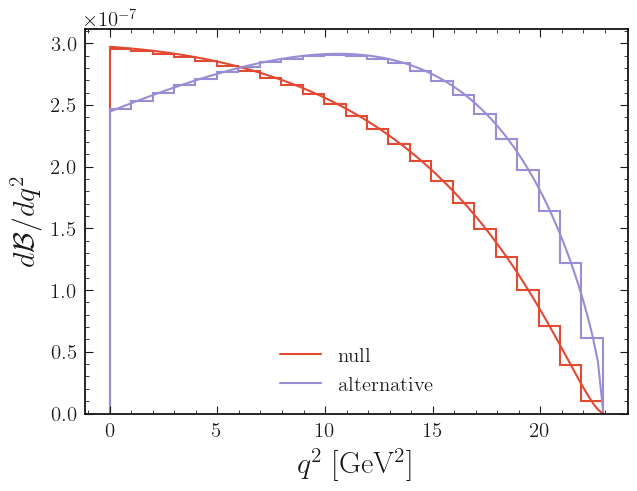

In [16]:
pars = (cvl, cvr, csl, csr, ctl, fp0, fp1, fp2, f01, f02, fT0, fT1, fT2)
lims = [0.0, 22.9]
labels = [r'$q^2$ [GeV$^2$]', r'$d\mathcal{B}/dq^2$']
plot.dists(cmod, pars, lims, labels)

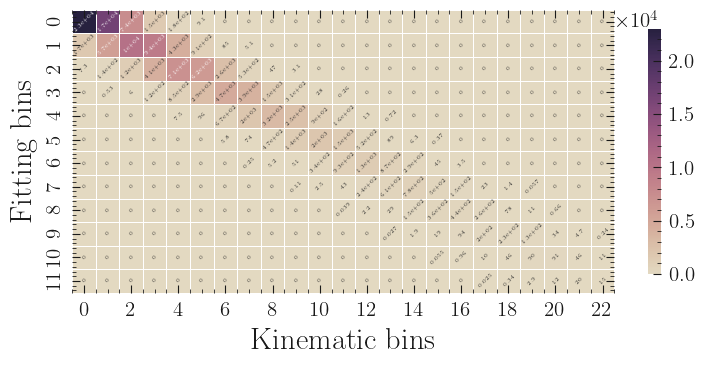

In [17]:
plot.map(cmod)

## Set up the model

In [18]:
spec = {
  "channels": [
    {
      "name": "B->Knunu",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "knunu_theory",
                "type": "knunu",
                "data":{"expr": "knunu_weight_fn"}
              }

model = modifier.add_to_model(model, ['B->Knunu'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'B->Knunu',
   'samples': [{'name': 'signal',
     'data': [48702.02333831797,
      32642.421364311707,
      21702.627146785588,
      14455.858600597798,
      9437.070605936751,
      6085.520643235089,
      3811.9958843149075,
      2340.614058692169,
      1337.3460626361978,
      705.0802856744019,
      292.76933949517706,
      69.96118731974],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'stat',
       'type': 'staterror',
       'data': [220.6853491700751,
        180.67213776427096,
        147.31811547391445,
        120.23251889816581,
        97.14458608659955,
        78.00974710403239,
        61.74136283169418,
        48.379893124025905,
        36.5697424469492,
        26.553347918377487,
        17.110503776779254,
        8.364280442437353]},
      {'name': 'knunu_theory',
       'type': 'knunu',
       'data': {'expr': 'knunu_weight_fn'}}]}]}]}

## Save and load model

In [19]:
modifier.save('knunu_model.json', model.spec, cmod, alt_yields)
model, alt_yields = modifier.load('knunu_model.json', alt.distribution, null.distribution, return_data=True)

data = alt_yields + model.config.auxdata

## Perform the fit

In [20]:
fixed = model.config.suggested_fixed()
fixed[model.config.par_map['mu']['slice']]  = [True]
fixed[model.config.par_map['cvr']['slice']] = [True]
fixed[model.config.par_map['csr']['slice']] = [True]

pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=2))
best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
    data,
    model,
    init_pars=best_fit.tolist(),
    fixed_params=fixed,
    return_uncertainties=True,
    return_fitted_val=True,
    return_result_obj=True
    )

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict


/home/lorenz/venv_redist/lib/python3.10/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


W MnPosDef Matrix forced pos-def by adding to diagonal 0.244308


{'cvl': array([5.90802632, 0.21601167]),
 'cvr': array([0.01, 0.  ]),
 'csl': array([1.79353353, 0.1345591 ]),
 'csr': array([0.01, 0.  ]),
 'ctl': array([1.2542937 , 0.16537628]),
 'FFK_decorrelated[0]': array([-0.10506824,  1.01084532]),
 'FFK_decorrelated[1]': array([0.25360486, 0.94013914]),
 'FFK_decorrelated[2]': array([0.20382512, 0.96998885]),
 'FFK_decorrelated[3]': array([-0.0863691 ,  0.98457617]),
 'FFK_decorrelated[4]': array([0.03372338, 0.99026738]),
 'FFK_decorrelated[5]': array([-0.01590694,  1.62888501]),
 'FFK_decorrelated[6]': array([0.019897  , 0.99287996]),
 'FFK_decorrelated[7]': array([0.00270888, 0.99331503]),
 'mu': array([1., 0.]),
 'stat': [[0.9987993239648018, 0.0042337726558577815],
  [1.0006916308893932, 0.004482009232397333],
  [1.002056150337404, 0.005325776524932546],
  [1.0033894014607512, 0.00646918261008711],
  [0.9983694289632745, 0.007902200426434247],
  [0.9937448808665591, 0.009608372336656956],
  [1.0002502513829632, 0.011829951967860464],
  [0

In [21]:
best_fit_rot = cmod.rotate_pars({k:v[0] if len(np.shape(v))==1 else [p[0] for p in v] for k, v in best_fit_dict.items()})
best_fit_rot

{'cvl': 5.9080263231497785,
 'cvr': 0.01,
 'csl': 1.7935335250573647,
 'csr': 0.01,
 'ctl': 1.2542936968559752,
 'FFK[0]': 0.3387504673451538,
 'FFK[1]': -0.8914439889323175,
 'FFK[2]': -0.15542290906872472,
 'FFK[3]': 0.38009735980226966,
 'FFK[4]': 0.08736677616286796,
 'FFK[5]': 0.3332650655193328,
 'FFK[6]': -0.9190601310294404,
 'FFK[7]': -0.22348799555673884,
 'mu': 1.0,
 'stat': [0.9987993239648018,
  1.0006916308893932,
  1.002056150337404,
  1.0033894014607512,
  0.9983694289632745,
  0.9937448808665591,
  1.0002502513829632,
  0.9959864695650772,
  1.006231783798587,
  0.9948570584952011,
  0.968421227722825,
  1.1137628166506996]}

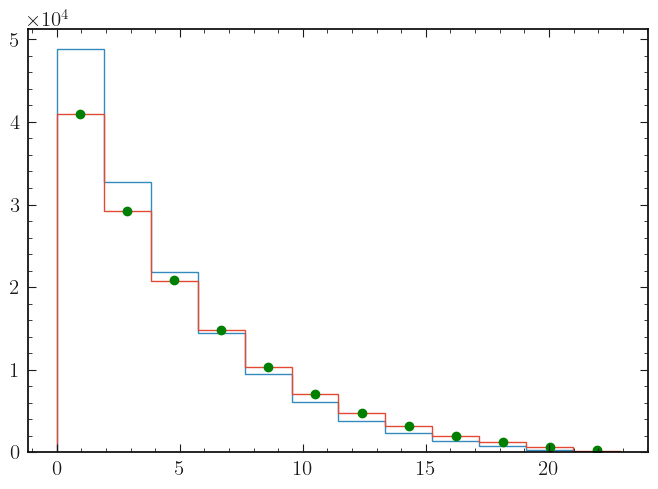

In [22]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), binning)
plt.stairs(model.expected_actualdata(best_fit[:,0]), binning)
bin_cents = (binning[:-1] + binning[1:])/2
plt.plot(bin_cents, alt_yields, 'og')